# Acoustic FWI(VP) with entire data

## Author: M. Ravasi

This notebook performs acoustic FWI parametrized in velocity using the entire dataset. It is identical to the ``AcousticVel_1stage`` notebook with the only difference that the loss function is computed ``L2Torch`` to showcase how one can couple ``devito-fwi`` with Torch in the computation of the loss function and its gradient (i.e., adjoint source) leveraging AD

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

from functools import partial
from scipy.ndimage import gaussian_filter
from scipy import signal
from scipy.optimize import minimize
from pylops.basicoperators import Identity

from devito import configuration
from tqdm.notebook import tqdm

from examples.seismic import AcquisitionGeometry, Model, Receiver
from examples.seismic import plot_velocity, plot_perturbation
from examples.seismic.acoustic import AcousticWaveSolver
from examples.seismic import plot_shotrecord

from devitofwi.devito.utils import clear_devito_cache
from devitofwi.waveengine.acoustic import AcousticWave2D
from devitofwi.loss.l2 import L2, L2Torch
from devitofwi.postproc.acoustic import create_mask_value, PostProcessVP

configuration['log-level'] = 'ERROR'

/home/ravasim/Documents/2024/Projects/Devito-fwi/devitofwi/waveengine/acoustic.py:9: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
# clear_devito_cache()

In [3]:
# Callback to track model error
def fwi_callback(xk, vp, vp_error):
    vp_error.append(np.linalg.norm((xk - vp.reshape(-1))/vp.reshape(-1)))

## Parameters 

In [4]:
# Model and aquisition parameters (in km, s, and Hz units)
par = {'nx':601,   'dx':0.015,    'ox':0,
       'nz':221,   'dz':0.015,    'oz':0,
       'ns':20,    'ds':0.300,    'os':1.,  'sz':0,
       'nr':300,   'dr':0.030,    'or':0,   'rz':0,
       'nt':3000,  'dt':0.002, 'ot':0,
       'freq':15,
      }

# Modelling parameters
shape = (par['nx'], par['nz'])
spacing = (par['dx'], par['dz'])
origin = (par['ox'], par['oz'])
space_order = 4
nbl = 20

# Velocity model
path = '../../data/'
velocity_file = path + 'Marm.bin'

## Acquisition set-up

In [5]:
# Sampling frequency
fs = 1 / par['dt'] 

# Axes
x = np.arange(par['nx']) * par['dx'] + par['ox']
z = np.arange(par['nz']) * par['dz'] + par['oz']
t = np.arange(par['nt']) * par['dt'] + par['ot']
tmax = t[-1]

# Sources
x_s = np.zeros((par['ns'], 2))
x_s[:, 0] = np.arange(par['ns']) * par['ds'] + par['os']
x_s[:, 1] = par['sz']

# Receivers
x_r = np.zeros((par['nr'], 2))
x_r[:, 0] = np.arange(par['nr']) * par['dr'] + par['or']
x_r[:, 1] = par['rz']

## Velocity model

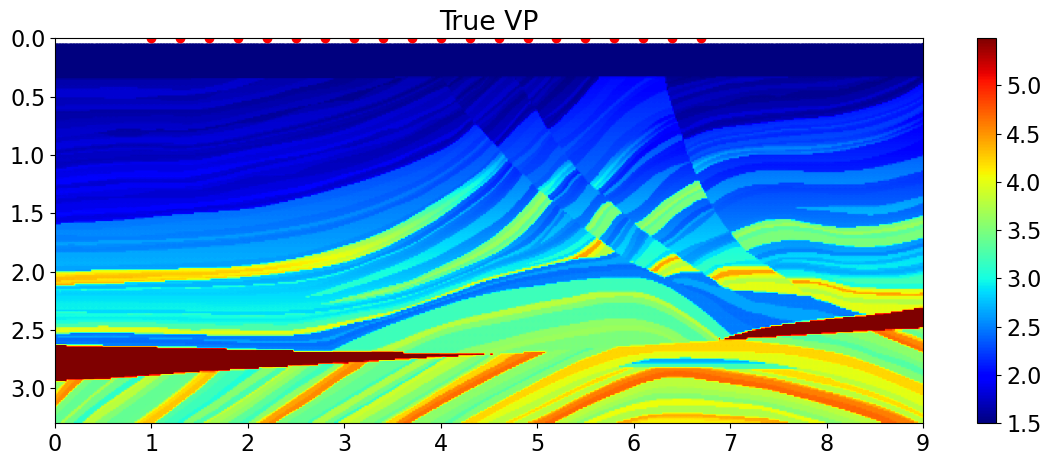

In [6]:
# Load the true model
vp_true = np.fromfile(velocity_file, np.float32).reshape(par['nz'], par['nx']).T
msk = create_mask_value(vp_true, 1.52) # get the mask for the water layer 

m_vmin, m_vmax = np.percentile(vp_true, [2,98]) 

plt.figure(figsize=(14, 5))
plt.imshow(vp_true.T, vmin=m_vmin, vmax=m_vmax, cmap='jet', 
           extent=(x[0], x[-1], z[-1], z[0]))
plt.colorbar()
plt.scatter(x_r[:,0], x_r[:,1], c='w')
plt.scatter(x_s[:,0], x_s[:,1], c='r')
plt.title('True VP')
plt.axis('tight');

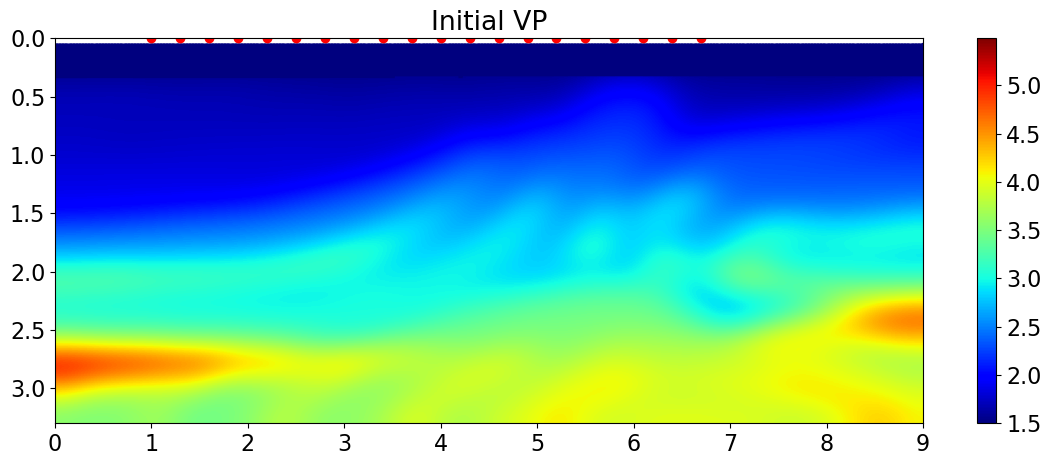

In [7]:
# Initial model for FWI by smoothing the true model
vp_init = gaussian_filter(vp_true, sigma=[15,10])
vp_init = vp_init * msk  # to preserve the water layer  
vp_init[vp_init == 0] = 1.5

plt.figure(figsize=(14, 5))
plt.imshow(vp_init.T, vmin=m_vmin, vmax=m_vmax, cmap='jet', 
extent=(x[0], x[-1], z[-1], z[0]))
plt.colorbar()
plt.scatter(x_r[:,0], x_r[:,1], c='w')
plt.scatter(x_s[:,0], x_s[:,1], c='r')
plt.title('Initial VP')
plt.axis('tight');

## Data modelling

In [8]:
amod = AcousticWave2D(shape, origin, spacing, 
                      x_s[:, 0], x_s[:, 1], x_r[:, 0], x_r[:, 1], 
                      0., tmax,  
                      vp=vp_true, 
                      src_type="Ricker", f0=par['freq'],
                      space_order=space_order, nbl=nbl,
                      clearcache=False)

# Create model and geometry to extract useful information to define the filtering object
model, geometry = amod.model_and_geometry()

In [9]:
# Model data
dobs, dtobs = amod.mod_allshots()

  0%|          | 0/20 [00:00<?, ?it/s]

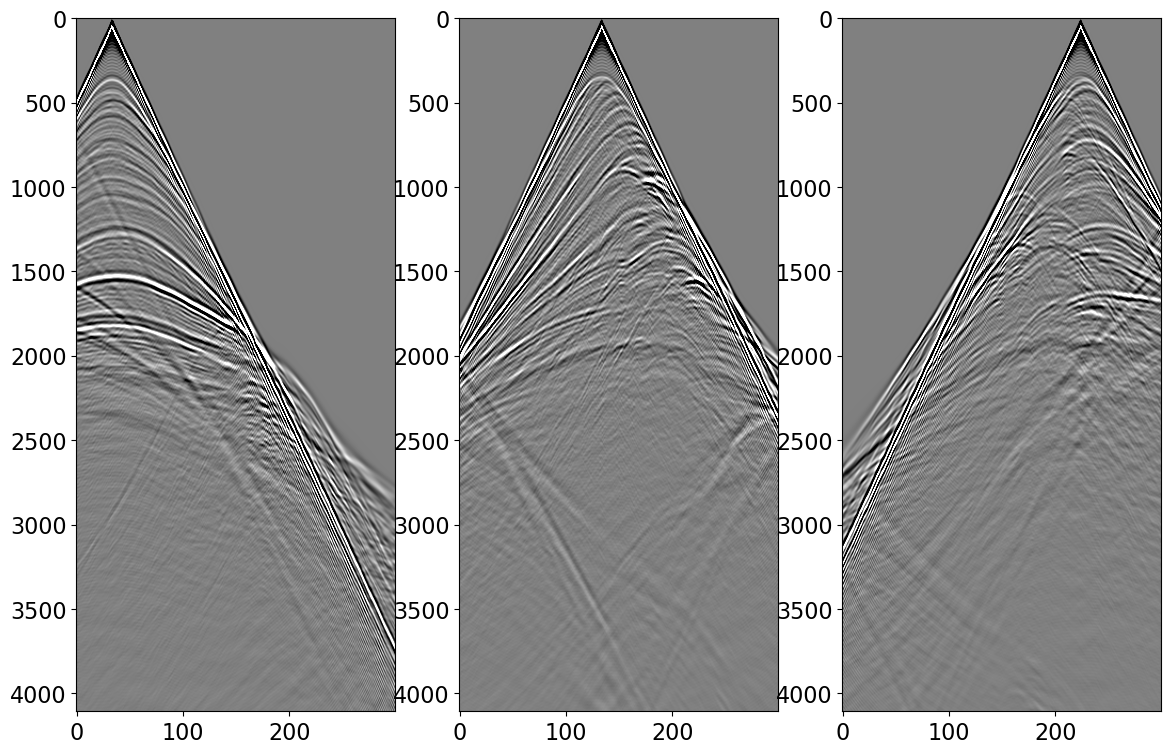

In [10]:
# Plot shot gathers
d_vmin, d_vmax = np.percentile(np.hstack(dobs).ravel(), [2, 98])

fig, axs = plt.subplots(1, 3, figsize=(14, 9))
for ax, ishot in zip(axs, [0, par['ns']//2, par['ns']-1]):
    ax.imshow(dobs[ishot], aspect='auto', cmap='gray',
              vmin=-d_vmax, vmax=d_vmax)

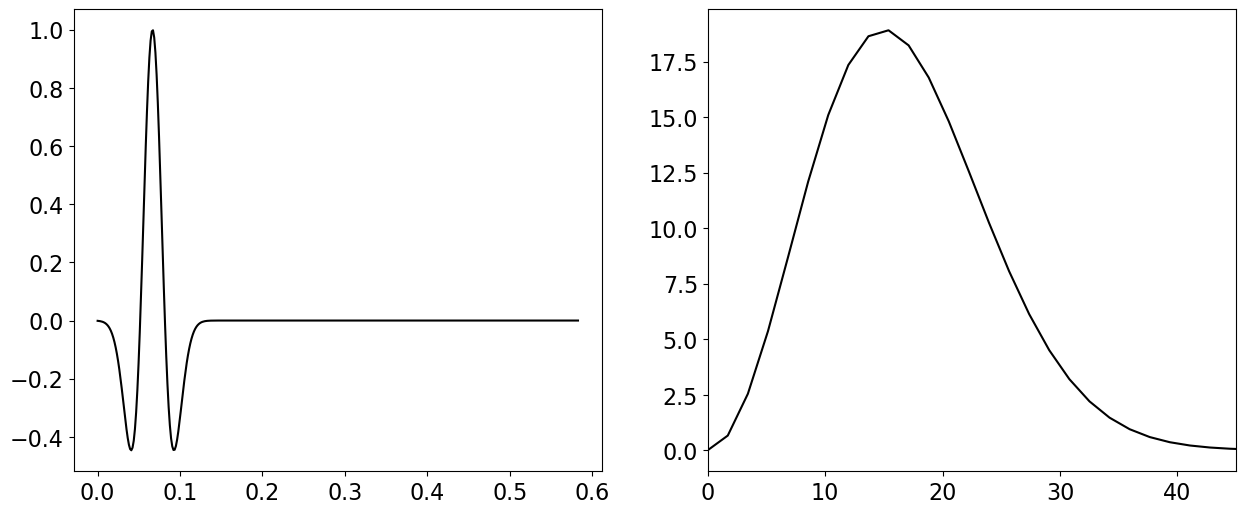

In [13]:
# Display wavelet
nwav = 400
wav = geometry.src.wavelet
f = np.fft.rfftfreq(nwav, geometry.dt)
WAV = np.fft.rfft(wav[:nwav], nwav)

fig, axs = plt.subplots(1, 2, figsize=(15, 6))
axs[0].plot(geometry.time_axis.time_values[:nwav], wav[:nwav], 'k')
axs[1].plot(f, np.abs(WAV), 'k')
axs[1].set_xlim(0, par['freq']*3);

## Inversion with L-BFGS

  0%|          | 0/20 [00:00<?, ?it/s]

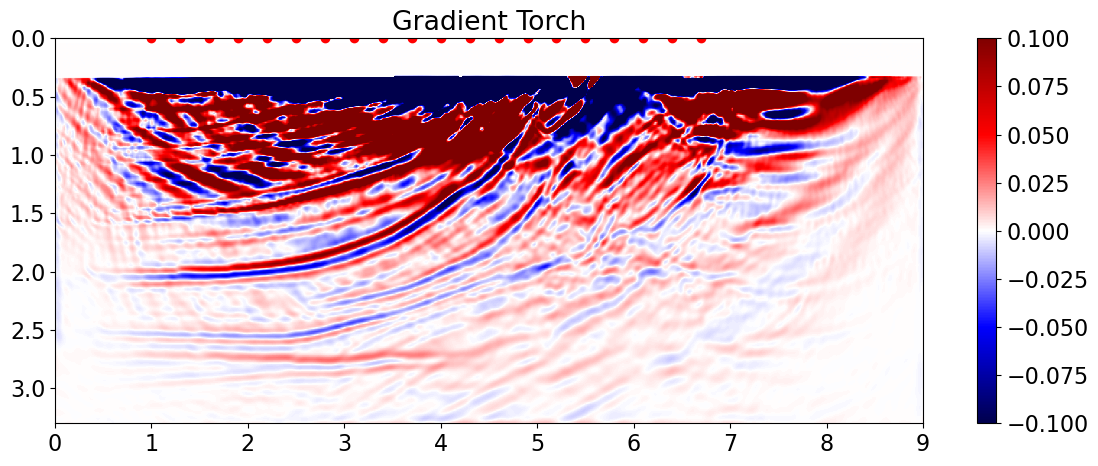

In [14]:
# L2 loss function with torch
l2losstorch = L2Torch(dobs.reshape(par['ns'], -1), Identity(int(np.prod(dobs.shape[1:]))))

ainvtorch = AcousticWave2D(shape, origin, spacing, 
                           x_s[:, 0], x_s[:, 1], x_r[:, 0], x_r[:, 1], 
                           0., tmax,  
                           vprange=(vp_true.min(), vp_true.max()),
                           src_type="Ricker", f0=par['freq'],
                           space_order=space_order, nbl=nbl,
                           loss=l2losstorch);

postproctorch = PostProcessVP(scaling=1, mask=msk)
losstorch, directiontorch = ainvtorch._loss_grad(vp_init, postprocess=postproctorch.apply)

scaling = directiontorch.max()

plt.figure(figsize=(14, 5))
plt.imshow(directiontorch.T / scaling, cmap='seismic', vmin=-1e-1, vmax=1e-1, 
           extent=(x[0], x[-1], z[-1], z[0]))
plt.colorbar()
plt.scatter(x_r[:,0], x_r[:,1], c='w')
plt.scatter(x_s[:,0], x_s[:,1], c='r')
plt.title('Gradient Torch')
plt.axis('tight');

In [15]:
# FWI with L-BFGS
ftol = 1e-10
maxiter = 200
maxfun = 5000
vp_error = []

postproc = PostProcessVP(scaling=scaling, mask=msk)

nl = minimize(ainvtorch.loss_grad, vp_init.ravel(), method='L-BFGS-B', jac=True,
              args=(None, postproc.apply),
              callback=lambda x: fwi_callback(x, vp=vp_true, vp_error=vp_error), 
              options={'ftol':ftol, 'maxiter':maxiter, 'maxfun':maxfun, 'disp':True})

  0%|          | 0/20 [00:00<?, ?it/s]

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =       132821     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.25928D+03    |proj g|=  5.45869D+00


 This problem is unconstrained.


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate    1    f=  1.09768D+03    |proj g|=  2.38218D+00


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate    2    f=  1.01400D+03    |proj g|=  1.84480D+00


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate    3    f=  9.04539D+02    |proj g|=  1.95629D+00


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate    4    f=  7.88819D+02    |proj g|=  3.48885D+00


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate    5    f=  7.25298D+02    |proj g|=  2.28496D+00


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate    6    f=  6.57556D+02    |proj g|=  2.47035D+00


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


At iterate    7    f=  6.11942D+02    |proj g|=  1.85844D+00


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate    8    f=  5.76677D+02    |proj g|=  6.70357D+00


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate    9    f=  5.38400D+02    |proj g|=  1.04297D+00


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   10    f=  5.16279D+02    |proj g|=  7.74480D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   11    f=  4.85987D+02    |proj g|=  1.88988D+00


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   12    f=  4.56913D+02    |proj g|=  1.28939D+00


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   13    f=  4.31501D+02    |proj g|=  9.24978D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   14    f=  4.15402D+02    |proj g|=  1.03596D+00


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   15    f=  3.94781D+02    |proj g|=  1.28880D+00


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   16    f=  3.83228D+02    |proj g|=  1.33819D+00


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   17    f=  3.69890D+02    |proj g|=  8.67924D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   18    f=  3.54363D+02    |proj g|=  9.36927D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   19    f=  3.43078D+02    |proj g|=  1.18524D+00


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   20    f=  3.33013D+02    |proj g|=  8.38715D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   21    f=  3.20565D+02    |proj g|=  6.67691D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   22    f=  3.09957D+02    |proj g|=  1.11295D+00


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   23    f=  2.96511D+02    |proj g|=  1.08747D+00


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   24    f=  2.86698D+02    |proj g|=  4.62102D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   25    f=  2.77325D+02    |proj g|=  5.08079D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   26    f=  2.68059D+02    |proj g|=  6.63164D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   27    f=  2.58831D+02    |proj g|=  6.51211D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   28    f=  2.52427D+02    |proj g|=  9.78074D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   29    f=  2.46899D+02    |proj g|=  5.50557D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   30    f=  2.39672D+02    |proj g|=  7.00701D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   31    f=  2.32712D+02    |proj g|=  6.58161D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   32    f=  2.26587D+02    |proj g|=  6.04323D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   33    f=  2.22250D+02    |proj g|=  4.31000D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   34    f=  2.17420D+02    |proj g|=  2.93550D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   35    f=  2.08395D+02    |proj g|=  4.67664D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   36    f=  2.05158D+02    |proj g|=  1.09436D+00


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   37    f=  1.98746D+02    |proj g|=  3.67115D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   38    f=  1.95372D+02    |proj g|=  3.13702D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   39    f=  1.90941D+02    |proj g|=  5.26721D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   40    f=  1.86003D+02    |proj g|=  1.15126D+00


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   41    f=  1.80853D+02    |proj g|=  5.04679D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   42    f=  1.77880D+02    |proj g|=  3.62565D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   43    f=  1.74750D+02    |proj g|=  3.86162D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   44    f=  1.71697D+02    |proj g|=  7.80640D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   45    f=  1.68134D+02    |proj g|=  5.07022D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   46    f=  1.64099D+02    |proj g|=  4.59604D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   47    f=  1.61985D+02    |proj g|=  5.05609D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   48    f=  1.55679D+02    |proj g|=  6.53868D-01


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   49    f=  1.53103D+02    |proj g|=  4.87206D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   50    f=  1.50269D+02    |proj g|=  4.19914D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   51    f=  1.46866D+02    |proj g|=  4.74430D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   52    f=  1.44108D+02    |proj g|=  4.36345D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   53    f=  1.41092D+02    |proj g|=  3.40089D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   54    f=  1.38795D+02    |proj g|=  4.93609D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   55    f=  1.37114D+02    |proj g|=  4.43398D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   56    f=  1.35249D+02    |proj g|=  3.45693D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   57    f=  1.33070D+02    |proj g|=  2.35043D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   58    f=  1.30177D+02    |proj g|=  2.12504D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   59    f=  1.27394D+02    |proj g|=  3.87368D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   60    f=  1.24866D+02    |proj g|=  5.34848D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   61    f=  1.22476D+02    |proj g|=  2.51078D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   62    f=  1.20258D+02    |proj g|=  2.72546D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   63    f=  1.17792D+02    |proj g|=  3.08829D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   64    f=  1.15446D+02    |proj g|=  4.76990D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   65    f=  1.13086D+02    |proj g|=  3.22284D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   66    f=  1.11303D+02    |proj g|=  4.51145D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   67    f=  1.10279D+02    |proj g|=  3.55048D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   68    f=  1.09164D+02    |proj g|=  2.77246D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   69    f=  1.06394D+02    |proj g|=  2.36279D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   70    f=  1.04699D+02    |proj g|=  3.50654D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   71    f=  1.02869D+02    |proj g|=  2.50394D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   72    f=  1.01558D+02    |proj g|=  2.85106D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   73    f=  1.00167D+02    |proj g|=  1.95850D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   74    f=  9.80513D+01    |proj g|=  2.65019D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   75    f=  9.64937D+01    |proj g|=  5.40361D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   76    f=  9.49269D+01    |proj g|=  2.57629D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   77    f=  9.37806D+01    |proj g|=  1.58844D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   78    f=  9.23914D+01    |proj g|=  3.00632D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   79    f=  9.14576D+01    |proj g|=  6.23412D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   80    f=  9.00863D+01    |proj g|=  2.69557D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   81    f=  8.92371D+01    |proj g|=  1.91822D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   82    f=  8.85036D+01    |proj g|=  2.44156D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   83    f=  8.66173D+01    |proj g|=  3.33047D-01


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   84    f=  8.55906D+01    |proj g|=  2.81298D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   85    f=  8.41633D+01    |proj g|=  1.60743D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   86    f=  8.30546D+01    |proj g|=  3.14171D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   87    f=  8.18984D+01    |proj g|=  2.53037D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   88    f=  8.08022D+01    |proj g|=  2.68400D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   89    f=  7.98525D+01    |proj g|=  3.46901D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   90    f=  7.87810D+01    |proj g|=  2.17822D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   91    f=  7.77319D+01    |proj g|=  2.39507D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   92    f=  7.67843D+01    |proj g|=  2.14157D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   93    f=  7.50770D+01    |proj g|=  2.89407D-01


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   94    f=  7.44410D+01    |proj g|=  1.40799D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   95    f=  7.33625D+01    |proj g|=  2.19836D-01


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   96    f=  7.30485D+01    |proj g|=  2.57404D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   97    f=  7.23966D+01    |proj g|=  2.25684D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   98    f=  7.12166D+01    |proj g|=  2.36804D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   99    f=  7.02120D+01    |proj g|=  2.95429D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate  100    f=  6.96296D+01    |proj g|=  1.34199D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate  101    f=  6.89230D+01    |proj g|=  1.53309D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate  102    f=  6.81551D+01    |proj g|=  2.20530D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate  103    f=  6.73042D+01    |proj g|=  5.06831D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate  104    f=  6.62318D+01    |proj g|=  1.78742D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate  105    f=  6.56490D+01    |proj g|=  1.23991D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate  106    f=  6.50055D+01    |proj g|=  1.96174D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate  107    f=  6.43552D+01    |proj g|=  2.93694D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate  108    f=  6.36439D+01    |proj g|=  1.87743D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate  109    f=  6.31610D+01    |proj g|=  1.47489D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate  110    f=  6.26385D+01    |proj g|=  1.52549D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate  111    f=  6.18440D+01    |proj g|=  1.73821D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate  112    f=  6.11356D+01    |proj g|=  1.81551D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate  113    f=  6.06608D+01    |proj g|=  1.48357D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate  114    f=  6.00769D+01    |proj g|=  1.43009D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate  115    f=  5.95837D+01    |proj g|=  1.49623D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate  116    f=  5.90401D+01    |proj g|=  1.20405D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate  117    f=  5.84855D+01    |proj g|=  1.48552D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate  118    f=  5.79692D+01    |proj g|=  1.58580D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate  119    f=  5.74472D+01    |proj g|=  1.61794D-01


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


At iterate  120    f=  5.71649D+01    |proj g|=  1.92031D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate  121    f=  5.69022D+01    |proj g|=  1.39020D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate  122    f=  5.66138D+01    |proj g|=  8.18658D-02


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate  123    f=  5.60983D+01    |proj g|=  1.06906D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate  124    f=  5.55231D+01    |proj g|=  1.53658D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate  125    f=  5.51617D+01    |proj g|=  3.20970D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate  126    f=  5.46659D+01    |proj g|=  1.20203D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate  127    f=  5.43775D+01    |proj g|=  1.34671D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate  128    f=  5.40457D+01    |proj g|=  1.52619D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate  129    f=  5.34859D+01    |proj g|=  2.11636D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate  130    f=  5.30734D+01    |proj g|=  3.24446D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate  131    f=  5.26056D+01    |proj g|=  1.14115D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate  132    f=  5.22563D+01    |proj g|=  1.57495D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate  133    f=  5.20167D+01    |proj g|=  1.41717D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate  134    f=  5.17034D+01    |proj g|=  1.48424D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate  135    f=  5.12836D+01    |proj g|=  1.22274D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate  136    f=  5.08262D+01    |proj g|=  1.75899D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate  137    f=  5.05389D+01    |proj g|=  1.50286D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate  138    f=  5.01987D+01    |proj g|=  8.82747D-02


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate  139    f=  4.98575D+01    |proj g|=  1.03066D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate  140    f=  4.95325D+01    |proj g|=  1.51141D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate  141    f=  4.92229D+01    |proj g|=  2.27441D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate  142    f=  4.87533D+01    |proj g|=  9.69524D-02


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate  143    f=  4.84684D+01    |proj g|=  1.05972D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate  144    f=  4.82131D+01    |proj g|=  1.21359D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate  145    f=  4.78477D+01    |proj g|=  2.80792D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate  146    f=  4.73983D+01    |proj g|=  1.31722D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate  147    f=  4.71320D+01    |proj g|=  9.81631D-02


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate  148    f=  4.67813D+01    |proj g|=  1.27191D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate  149    f=  4.65222D+01    |proj g|=  3.68104D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate  150    f=  4.61885D+01    |proj g|=  2.03832D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate  151    f=  4.57438D+01    |proj g|=  1.22583D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate  152    f=  4.54992D+01    |proj g|=  1.59478D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate  153    f=  4.51796D+01    |proj g|=  3.11479D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate  154    f=  4.47953D+01    |proj g|=  1.25381D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate  155    f=  4.46217D+01    |proj g|=  8.98788D-02


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate  156    f=  4.43820D+01    |proj g|=  1.24738D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate  157    f=  4.43279D+01    |proj g|=  3.07173D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate  158    f=  4.39344D+01    |proj g|=  1.48131D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate  159    f=  4.37436D+01    |proj g|=  9.19915D-02


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate  160    f=  4.35798D+01    |proj g|=  8.13339D-02


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate  161    f=  4.33661D+01    |proj g|=  1.06332D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate  162    f=  4.29378D+01    |proj g|=  2.70050D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate  163    f=  4.25465D+01    |proj g|=  1.42160D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate  164    f=  4.23181D+01    |proj g|=  1.02524D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate  165    f=  4.21040D+01    |proj g|=  9.99974D-02


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate  166    f=  4.18777D+01    |proj g|=  1.11305D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate  167    f=  4.16077D+01    |proj g|=  1.90078D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate  168    f=  4.12935D+01    |proj g|=  1.18082D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate  169    f=  4.11102D+01    |proj g|=  1.08764D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate  170    f=  4.08797D+01    |proj g|=  1.34226D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate  171    f=  4.06500D+01    |proj g|=  1.66054D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate  172    f=  4.04716D+01    |proj g|=  9.32981D-02


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate  173    f=  4.02673D+01    |proj g|=  9.82710D-02


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate  174    f=  4.00232D+01    |proj g|=  1.38372D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate  175    f=  3.97450D+01    |proj g|=  2.37190D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate  176    f=  3.95035D+01    |proj g|=  1.04106D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate  177    f=  3.93197D+01    |proj g|=  1.23368D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate  178    f=  3.90624D+01    |proj g|=  1.46694D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate  179    f=  3.89324D+01    |proj g|=  1.91801D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate  180    f=  3.86684D+01    |proj g|=  7.02368D-02


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate  181    f=  3.85301D+01    |proj g|=  7.27236D-02


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate  182    f=  3.83491D+01    |proj g|=  1.04910D-01


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


At iterate  183    f=  3.82448D+01    |proj g|=  1.16161D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate  184    f=  3.80557D+01    |proj g|=  8.72683D-02


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate  185    f=  3.78543D+01    |proj g|=  7.71205D-02


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate  186    f=  3.75666D+01    |proj g|=  1.02467D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate  187    f=  3.74816D+01    |proj g|=  2.14866D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate  188    f=  3.72307D+01    |proj g|=  7.13636D-02


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate  189    f=  3.70944D+01    |proj g|=  6.68450D-02


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate  190    f=  3.69205D+01    |proj g|=  8.49996D-02


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate  191    f=  3.66789D+01    |proj g|=  1.25974D-01


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


At iterate  192    f=  3.65812D+01    |proj g|=  9.77276D-02


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate  193    f=  3.63185D+01    |proj g|=  1.00354D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate  194    f=  3.61014D+01    |proj g|=  1.31618D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate  195    f=  3.58964D+01    |proj g|=  1.33957D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate  196    f=  3.57603D+01    |proj g|=  6.64181D-02


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate  197    f=  3.57002D+01    |proj g|=  7.12688D-02


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate  198    f=  3.54895D+01    |proj g|=  9.23581D-02


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate  199    f=  3.51730D+01    |proj g|=  9.00704D-02


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


At iterate  200    f=  3.50195D+01    |proj g|=  1.06851D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
*****    200    211      1     0     0   1.069D-01   3.502D+01
  F =   35.019519805507102     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


In [16]:
nl

  message: STOP: TOTAL NO. of ITERATIONS REACHED LIMIT
  success: False
   status: 1
      fun: 35.0195198055071
        x: [ 1.500e+00  1.500e+00 ...  3.819e+00  3.805e+00]
      nit: 200
      jac: [ 0.000e+00  0.000e+00 ...  7.964e-04  8.740e-04]
     nfev: 211
     njev: 211
 hess_inv: <132821x132821 LbfgsInvHessProduct with dtype=float64>

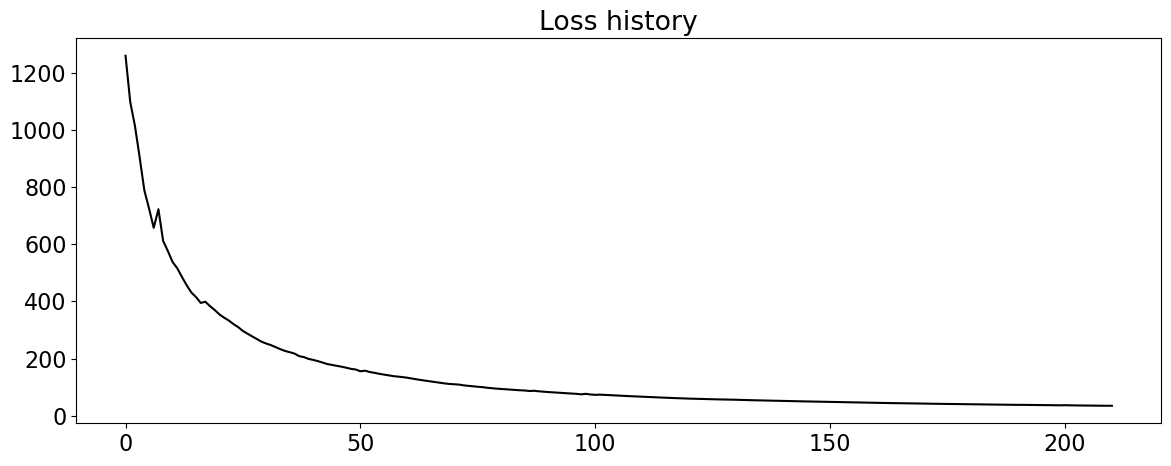

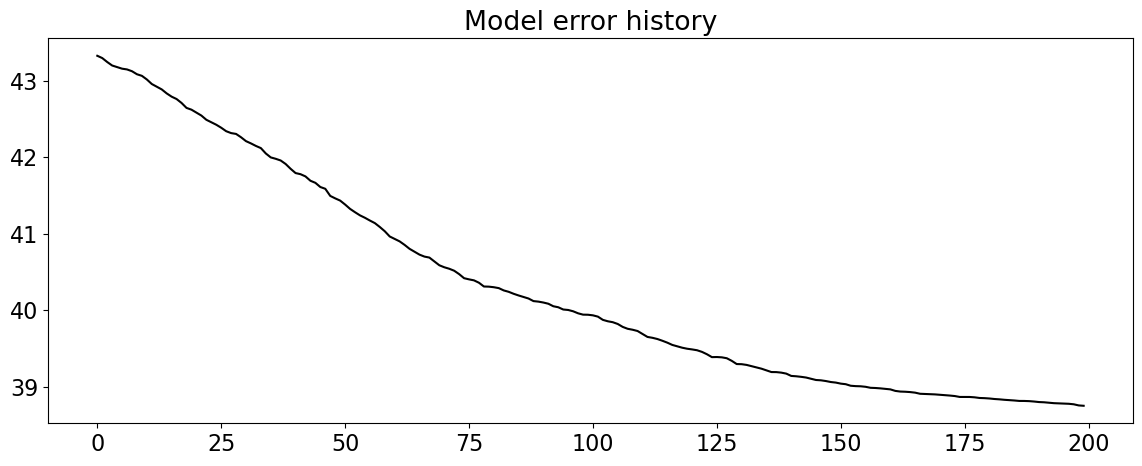

In [17]:
plt.figure(figsize=(14, 5))
plt.plot(ainvtorch.losshistory, 'k')
plt.title('Loss history')

plt.figure(figsize=(14, 5))
plt.plot(vp_error, 'k')
plt.title('Model error history');

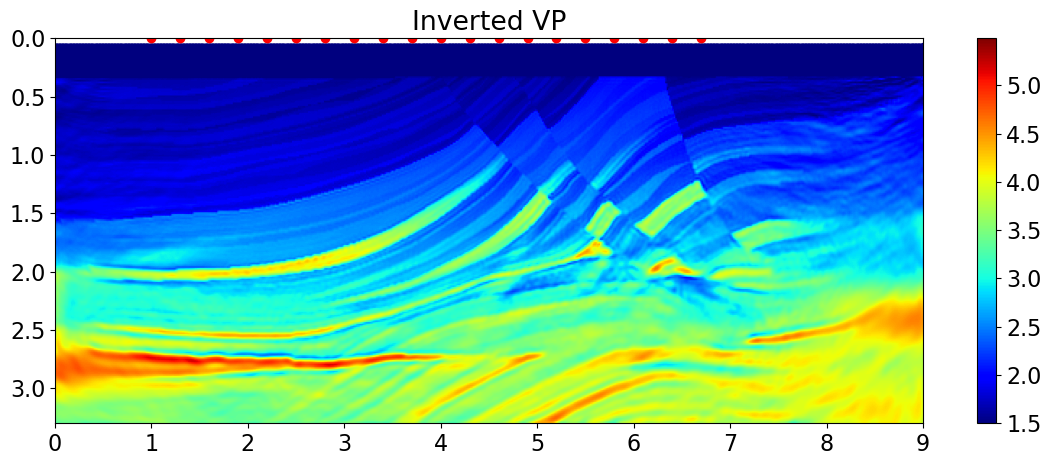

In [18]:
vp_inv = nl.x.reshape(shape)

plt.figure(figsize=(14, 5))
plt.imshow(vp_inv.T, vmin=m_vmin, vmax=m_vmax, cmap='jet', extent=(x[0], x[-1], z[-1], z[0]))
plt.colorbar()
plt.scatter(x_r[:,0], x_r[:,1], c='w')
plt.scatter(x_s[:,0], x_s[:,1], c='r')
plt.title('Inverted VP')
plt.axis('tight');

In [21]:
# Model data with inverted velocity model and compare with observed data
ainvfinal = AcousticWave2D(shape, origin, spacing, 
                           x_s[:, 0], x_s[:, 1], x_r[:, 0], x_r[:, 1], 
                           0., tmax,  
                           vp=vp_inv, 
                           src_type="Ricker", f0=par['freq'],
                           space_order=space_order, nbl=nbl)

dinv = ainvfinal.mod_allshots(dt=dtobs)[0]

  0%|          | 0/20 [00:00<?, ?it/s]

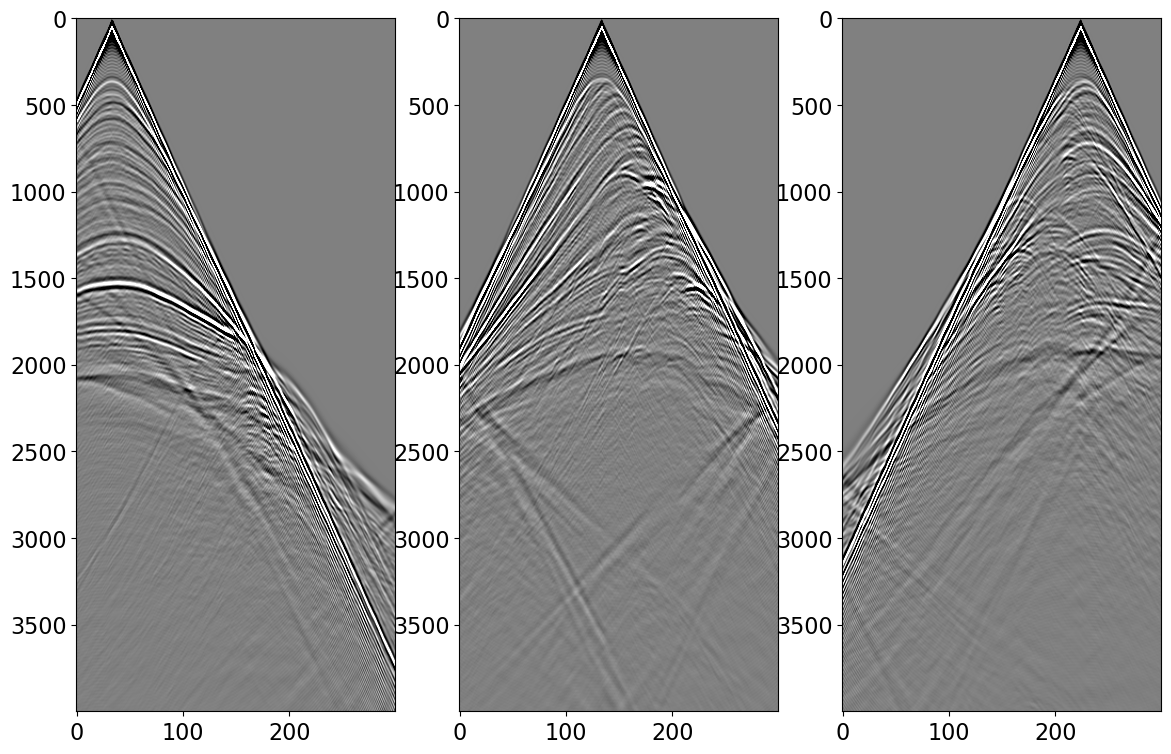

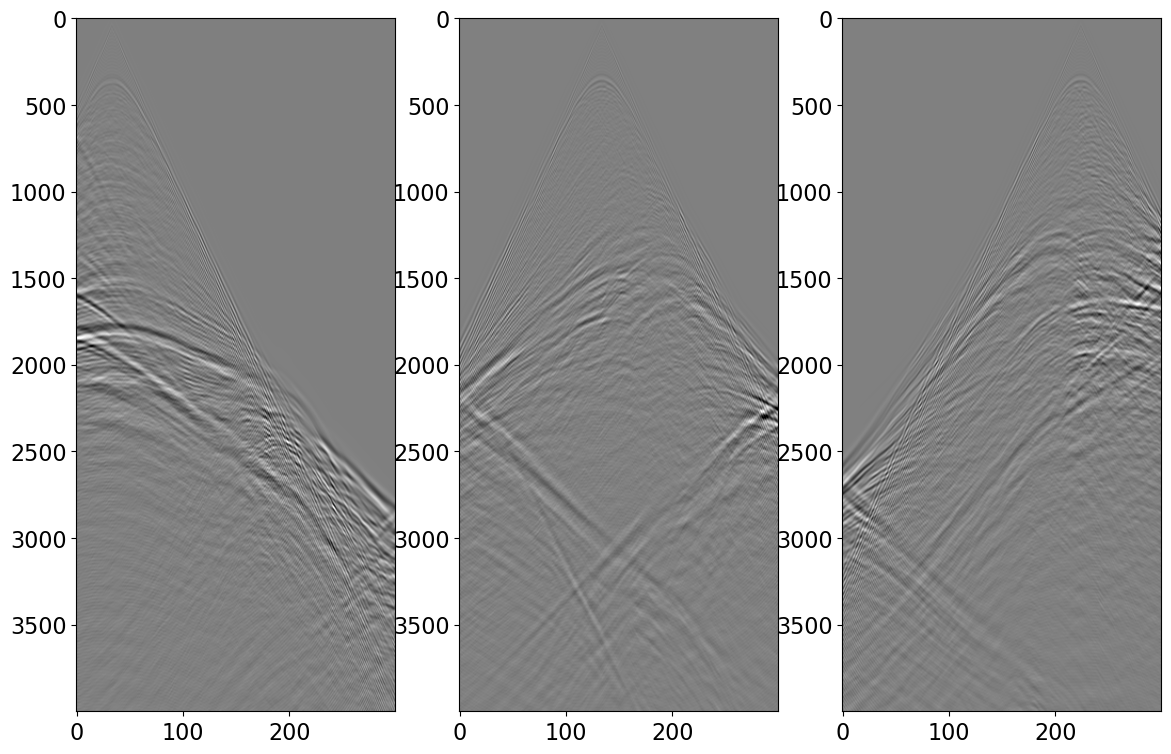

In [22]:
ntmax = 4000
d_vmin, d_vmax = np.percentile(np.hstack(dinv).ravel(), [2, 98])

fig, axs = plt.subplots(1, 3, figsize=(14, 9))
for ax, ishot in zip(axs, [0, par['ns']//2, par['ns']-1]):
    ax.imshow(dinv[ishot, :ntmax], aspect='auto', cmap='gray',
              vmin=-d_vmax, vmax=d_vmax)

fig, axs = plt.subplots(1, 3, figsize=(14, 9))
for ax, ishot in zip(axs, [0, par['ns']//2, par['ns']-1]):
    ax.imshow(dobs[ishot, :ntmax] - dinv[ishot, :ntmax], aspect='auto', cmap='gray',
              vmin=-d_vmax, vmax=d_vmax)